In [20]:
import PIL
from PIL import Image
import pandas as pd
import numpy as np
import cv2
import os
import glob
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import shutil
from datetime import datetime
from yellowbrick.cluster import KElbowVisualizer
import openpyxl
from openpyxl import load_workbook
import xlsxwriter

pd.options.display.float_format = '{:.2f}'.format

In [56]:
def vectorize_image(path):
    
    '''
    Using OS library,read the directory path,directory name and files names of the directory.For each of the image files,
    convert the image into pixel using the OpenCV library.
    This function performs the following activity
    Creates a dataframe where the number of columns = n x n (size of the image) and rows = number of images.
    Creates a list of labels corresponding to the digit represented by each of the images. 
    
    Arguments:-
    path =  The directory path which has the images to be converted to a corresponding dataframe 
            where each image is a vector of n*n
            where the image is of the size n x n pixels
    
    Returns :-
    df_images = Dataframe holding pixel values of each image
    labels = The digit represented by each of the images. 
   
    '''
                   
    labels=[]                  #List to hold lable name for image ie digit the images belongs to.      
    df_images=pd.DataFrame()   # Dataframe to hold the pixel values of every image
    
    for clustdir in os.listdir(path):
        lab_name=int(clustdir)
    
        for file_name in os.listdir(os.path.join(path, clustdir)):
        
            img=cv2.imread(os.path.join(path,clustdir,file_name),0)
            img_flat=img.flatten()                           #Flattern array to single dimension
            img_flat=pd.Series(img_flat)
            labels.append(lab_name) 
            df_images=df_images.append(img_flat,ignore_index=True)

    
    return df_images,pd.Series(labels)
    
    

In [61]:
def dir_user_input():
    '''
    Ask the user to enter the directory path where the folders containing the images are present.
    Keeps asking the user till the user enters a valid path 
    
    '''
    while True:    
        dir_path=input('Enter directory path, do not enclose in quotes       :-  ')
        
        if os.path.isdir(dir_path):
            return vectorize_image(dir_path)
        else:
            print ("Directory not exists. Re- Enter")

In [62]:
def pca_transform(fitdata,transformdata,variance):
    '''
    The function creates a PCA object. The data is fit and transformed on the object. 
    
    Arguments:-
    data= Dataframe holding pixel values
    variance= percentage of variance needed to 
    
    Returns :- Transformed data as per the percentage of variance 
    
    ''' 
    pca = PCA(variance)
    pca.fit(fitdata)
    data_transformed=pca.transform(transformdata)
    
    return pd.DataFrame(data_transformed)

In [63]:
def kmean_cal(cluster_data,km_val):
    
    '''
    Calculated Kmean with Kmean library.
    
    Argument :-
    cluster_data - Cluster data to build the model
    km_val= k values
    
    Return :-
    km :- kmean object
    km.labels :- Kmean labels
    km.n_iter :-kmean inertia
    
    
    '''
            
    km = KMeans(n_clusters=km_val ,random_state=0).fit(cluster_data)
    
        
    return km,km.labels_,km.inertia_,km.n_iter_


In [64]:
def plot_elbow_graph(clust_dist):
    '''
    The function is to plot a graph with k values and inertia for each of the k value. This helps in getting an optimal k value
    by the means of elbow point on the graph.
    
    Argument :- 
    clust_dist = dictionary with k and intertia value
          
    '''
    
    plt.plot(*zip(*sorted(clust_dist.items())))
    plt.xlabel('Number of cluster')
    plt.ylabel('Total distance')
    plt.show()
    

In [65]:
def diff_in_inertia(clust_dict,pca_var,df_diff):
    
    '''
    The function is used to calculate the difference in inertia between consecutive k values.
    For eg :- k in range [2,3,4,5,6,7].The difference in inertia will be calculated between k-2 and k-3, then k-3 and k-4 till the end.
    The least difference between inertia value for a given k is stored in the data frame.
    
    Argument :-
    clust_dict - dictionary to hold k value and respective inertia values
    pca_var - PCA variance
    df_diff -  dataframe to hold the least inertia difference and k-value
    
    Return
    df_diff -  dataframe to hold the least inertia difference and k-value
    
    
    '''
    
    
    #Find the minimum difference between adjacent inertia for a given k values
    temp_clust={}              #Dictionary to hold the difference in inertia for a given k.

    diff=0

    for k1 in clust_dict:
        if k1+1 in clust_dict.keys():
        
            diff=(clust_dict.get(k1)) - (clust_dict.get(k1+1))
        
            temp_clust.update({(k1):diff})
    
    
    min_v=min(zip(temp_clust.values(), temp_clust.keys()))
   
    #Populating the dataframe with PCA variance,least inertia for a given k, values,k value
    df_diff.loc[len(df_diff)+1]=[pca_var,min_v[1],min_v[0]]

    
    return df_diff
 

In [86]:
def silhouette_KElbow(train_data):
    
    '''
    The function is to create a graph with Silhouette coefficient data.
    
    Argument :-
    train_data :- train transformed data.
    '''

    # Instantiate an scikit-learn K-Means model
    model = KMeans(random_state=0)

    # Instantiate the KElbowVisualizer with the number of clusters and the metric
    visualizer = KElbowVisualizer(model, k=(2,23), metric='silhouette', timings=False)

    # Fit the data and visualize
    visualizer.fit(train_data)    
    visualizer.poof() 

In [67]:
def create_base_dir(main_dir,comp):
    '''
    This Function is to create base_dir to hold the recreated images in respective k values and label subfolders. Naming convention is
    followed to have a history of data for a particular date, PCA variance.
    Name of the subdirectory is the current date, time and PCA variance
    Main directory eg D:\Project-Hand-Written-Character-reco\label-dir
    Name of the subdirectory is current date,time and PCA variance eg (D:\Project-Hand-Written-Charcter-reco\label-dir\04-10-11-07-0.99
    
    
    Argument :-
    main_dir = base path for further sub directory.
    comp - PCA variance.
    
    Return :- 
    pca_dir :- directory path to further create k and cluster number subfolders.
    '''
    
    now = datetime.now()
    dt_string = now.strftime("%d-%m-%H-%M")
    sub_dir=('%s-%s' %(dt_string,comp))
    pca_dir = os.path.join(main_dir,sub_dir) # Create a base directory 
    
    
    return pca_dir

In [68]:
def create_lab_dir(path,label):
    '''
    Create the directories with the name as the label for a given k value. 
    Delete directories if there already exist.
    
    Argument:-
    path - Path where you want to create sub-directories
    label - labels for a given k value.
    
    '''
    
    for root, dirs, files in os.walk(path): 
        for name in files:                #Delete previously existing recreated images.
            os.remove(os.path.join(root, name))
  
            
#Create new sub-directories

    for x in label.unique(): #Get unique values of the labels to create a respective subfolder under the base directory..
          
        # create dynamic name, like "D:\Current Download\Attachment82673"
        lab_dir_path = os.path.join(path, '%s' %x ) #Path to create label folders for a given k eg 05-10-12-51-0.98\2
        
        if not os.path.exists(lab_dir_path):
            os.makedirs(lab_dir_path)

In [69]:
def recreate_image(train_data,k_label_df,base_dir_path,pca_var):
    
    '''
    This function is to recreate the images from pixel data and save them in their respective label directories for a given k.
    
    Argument :- 
    train_data - train transformed data.
    k_label_df - label dataframe for a given k value.
    base_dir_path -path to the base directory to create further subdirectories.
    pca_var - PCA variance.
    
    '''
    
    
    pca_folder =  create_base_dir(base_dir_path,pca_var)    #To create base_dir for PCA variance eg:- '05-10-12-51-0.98'
    
    for col in k_label_df.columns:  #Loop through label dataframe for k values.
        col_s=k_label_df[col]
        col_series=pd.Series(col_s,index=k_label_df.index) #Convert each column to series.
        for unq in col_series.unique():
            
            k_sub_dir=('%s' %(col))     
            lab_dir=os.path.join(pca_folder,k_sub_dir)  #Create folders for each k values under base dir 
            create_lab_dir(lab_dir,col_series)  # Create  directory to save the recreated images
                
            for ind ,val in zip(train_data,col_series.index): #Loop through training data index and label dataframe colum index
        
                if ind==val:   #Check if both indexs are matching.

                    #Get the label directory path to save the image.
                    lab_dir_path = os.path.join(lab_dir, '%s' %col_series[ind] ) 
                    
                    flat_numpy_array = np.array(train_data.loc[[ind]]) #Recreate image of the row present at given index location.
                    grey_image=flat_numpy_array.reshape(28, 28)
                   
                    cv2.imwrite(os.path.join(lab_dir_path, "%s.png" %ind), grey_image) #Save file under respective label subfolder.
 

In [70]:
def create_excel(dir_file):
    
    '''
    The function is to create an object of excelwriter pointing to a excel file name and location passed as argument.
    
    Argrument :-
    dir_file :- directory path with file name
    
    Return :-
    Object of excel workbook
    '''
      
    book=pd.ExcelWriter(dir_file, engine='openpyxl') #Create an excel file in the given location.
    
    return book

    

In [71]:
def write_to_excel(df,writer,sheetname,path):
    
    '''
    This function is to write the output to excel file.
    
    Argument :-
    df- Dataset to export to the excel file
    writer - object of the excel file
    sheetname - Name of the sheet in the excel file.
    path - Location of the excel file
    
    Return :-
    Object of excel file
     
    '''
    
    
    if os.path.exists(path):
        
        
        wb=load_workbook(path)
        if sheetname in wb.sheetnames:
                start_row=wb[sheetname].max_row
                start_row=start_row+2
                df.to_excel(writer,sheet_name=sheetname,startrow=start_row,startcol=0,engine='openpyxl')
                writer.close()

        else:
            df.to_excel(writer,sheet_name=sheetname,startrow=0,startcol=0,engine='openpyxl')
            writer.close()
           
                        
    else:
            
        df.to_excel(writer,sheet_name=sheetname,startrow=0,startcol=0,engine='openpyxl')
        writer.close()
  
    
    return writer
    
    

In [72]:
def image_in_cluster(k_label_df,train_lab_lst,pca_var,book,path):
    '''
    The function manually counts the number of images for a given class in a cluster. The function compares the index location
    of the original digit in the train_label list and k label list. For the matching index, the corresponding digit is incrementally
    counted and populated in the respective columns(named after label values) in the data frame.
    Data frame is exported to an excel file.This is done for each PCA variance.
    Dataframe is cleared before reuse.
   
    
    Argument :-
    k_label_df - k label dataframe
    train_lab_lst  -actual label of the image
    pca_var - PCA variance
    book - excel file path and name
    
    Return:-
    excel book object
    
    
    '''
    start_row=0
    row=sorted(train_lab_lst.unique())
    
    
    
    for col in k_label_df.columns:
        col_s=label_df[col]
        col_series=pd.Series(col_s,index=label_df.index)
        sorted_clust= sorted(col_series.unique())
        data= np.zeros(shape=(len(row),len(sorted_clust)))
        count_df=pd.DataFrame(data,columns=[sorted_clust],index=(row))
      
        for ind,val in col_series.iteritems():
    
            img_num=int(train_lab_lst[ind])

            count_df.iat[img_num,val]=count_df.iat[img_num,val]+1
            
        sheetname='count_img%s' %pca_var
       
        write_to_excel(count_df,book,sheetname,path)
    
        count_df.iloc[0:0]
        count_df=count_df.dropna(axis=1,inplace=True)
    
    
    

In [73]:
def analysis_dataframes():
    '''
    Data Frames are created to hold the output after executing k values.
    
    Return :- 
    k_val -           k mean values
    inertia_df -      Dataframe to hold inertia values for given k_value and given PCA variance
    coeff -          Dataframe to hold the Silhouette coefficient for given k_value and given PCA variance.
    inertia_diff -   Dataframe to hold minimum inertia value for a given k and given PCA variance.
    label -          Dataframe to hold labels for all k_value.
    
    '''
    
    k_val=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
    ind=[0.96,0.97,0.98,0.99]
    inertia_df=pd.DataFrame(columns=[k_val],index=(ind))
    coeff=pd.DataFrame(columns=[k_val],index=(ind))
    inertia_diff=pd.DataFrame(columns=['PCA','k_value','Difference'])
    label=pd.DataFrame()
    
    return k_val,inertia_df,coeff,inertia_diff,label

In [ ]:
#User input for directory path holding images.

train_pixel_data,train_label_lst=dir_user_input()

In [ ]:
#User input for PCA variance

#comp= Variance of PCA

comp=input('Enter the number of PCA variance in whole number only      :- '
          )
if '.' in comp:
    comp=float(comp)
    train_pca_data=pca_transform(train_pixel_data,train_pixel_data,comp)
    

In [76]:
 # Create an excel file at a given path and file name.
excel_path ='D:\\kmean.xlsx'
workbook = create_excel(excel_path)


In [77]:
#Create dataframe for given k values
k_value,k_inertia_df,coeff_df,inertia_diff_df,label_df=analysis_dataframes()

In [78]:
'''
Run multiple k values. For each k values get the labels, inertia values. We recreate the image and save them in base_dir\kmean\cluster_number format subfolder created earlier
The data frame is populated with clusters and inertia . The data frame is then converted to an excel file.
To cross verify the formation and composition of the cluster 
with the actual digit label, we automate the task of counting the image for a given digit in each cluster.

k_value -           k mean values
k_inertia_df -      Dataframe to hold inertia values for given k_value and given PCA variance
coeff_df -          Dataframe to hold the Silhouette coefficient for given k_value and given PCA variance.
inertia_diff_df -   Dataframe to hold minimum inertia value for a given k and given PCA variance.
label_df -          Dataframe to hold labels for all k_value.


'''
pd.options.display.float_format = '{:.2f}'.format


clust_tot_dist={}    #To hold the k values and their respective inertia

for y in k_value:
        label_clust=pd.Series(np.zeros(train_pca_data.shape[0]))  
        kmean_obj,label,inertia,niter=kmean_cal(train_pca_data,y)  #Convert the image to pixel values
        label_clust=pd.Series(label)
        
        clust_tot_dist.update({y:inertia})  
        
        k_inertia_df.at[comp,y]=float(inertia)
        sil_coeff = metrics.silhouette_score(train_pca_data,label_clust,metric='euclidean',random_state=0)
        coeff_df.at[comp,y]=sil_coeff
        label_df[y]=label_clust
        #workbook=image_in_cluster(label_clust,train_label_lst,comp,workbook,excel_path)
        
inertia_diff_df=diff_in_inertia(clust_tot_dist,comp,inertia_diff_df)   # To populate dataframe with difference in inertia value




In [ ]:
#To check the inertia for given k values and with the PCA range of (0.96-0.99).


flag=input('Enter yes to export dataframe data to an excel file else enter no       :-  ')

if flag=='yes':
    sheet='k-inertia'
    write_to_excel(k_inertia_df,workbook,sheet,excel_path)
    workbook.close()
    


In [ ]:
#To check the difference in inertia for k given values and with the PCA range of (0.96 - 0.97)

flag=input('Enter yes to export dataframe data to an excel file else enter no       :-  ')

if flag=='yes':
    sheet='Inertia_Diff'
    workbook=write_to_excel(inertia_diff_df,workbook,sheet,excel_path)
    

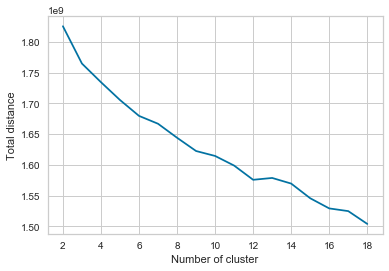

In [81]:
#Create an elbow graph with a dictionary populated with k values and inertia for a given PCA variance.
plot_elbow_graph(clust_tot_dist)

In [ ]:
#To check the Silhouette coefficient values for given k values and with the PCA range of (0.96 - 0.97).

flag=input('Enter yes to export dataframe data to an excel file else enter no       :-  ')

if flag=='yes':
    sheet='Sihoutte'
    workbook=write_to_excel(coeff_df,workbook,sheet,excel_path)


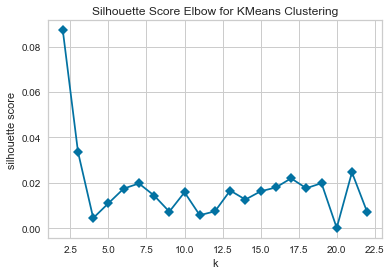

In [87]:
silhouette_KElbow(train_pca_data)

In [ ]:
#Recreate image. To be run after k values and for a given PCA variance.
base_dir = 'D:\Project-Hand-Written-Charcter-reco\label-dir'

flag=input('Do you want to recreate the image yes/no)       :-  ')

if flag=='yes':
    recreate_image(train_pixel_data,label_df,base_dir,comp)
    


In [ ]:
#Execute this after every k values and for a given PCA variance.
flag=input('Do you want to count the image in each cluster and populate in an excel file(yes/no)       :-  ')

if flag=='yes':
    image_in_cluster(label_df,train_label_lst,comp,workbook,excel_path)